Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph

categories:[multimodal learning, deep learning, Transformer, Graph]

Motivation
In the article 'Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph', the MMFDL model is used for predicting drug properties. We tested the model using six single-molecule datasets, including Delaney, Llinas2020, Lipophilicity, SAMPL, BACE and pKa from DataWarrior. 
In this post, we use the SAMPL dataset for how to train MMFDL model. The input of the model is to convert drug molecules into three molecular representations: SMILES-encoed vectors、ECFP fingerprints and molecular graphs. To process the modal nformation, Transformer-Ecoder、BiGRU and graph convolutional network(GCN) are utilized for feature learning respectively. Then this model uses five fusion methods to capture specific features.

I'll use SAMPL dataset as an example. The SAMPL dataset from MoleculeNet is a statistical evaluation dataset fro protein and ligand modeling and consists of 642 experimental values logP.

The overall structure of the multimodal fused deep learning (MMFDL) model. Blue, orange and green color lines represent the data flow in the model for training, tuning, and test sets. SMILES-encoded vectors are processed by Transformer-Encoder, ECFP is processed by BiGRU with MultiHead Attention, and Graph is processed by GCN model. The training set is used to train the feature extraction model; the validation set determines the hyperparameters of the feature extraction model. The tuning set is used to assign the weights for each modal input. The test set is used to validate the prediction performance.

In this part, we compute the weights of the different models after splicing the three learned multimodal feature outputs using four methods based on maching learning methods for combination, which are refered to as Tri_LASSO, Tri_Elastic, Tri_RF and Tri_GB by using LASSO, Elastic Net, RF and GB.

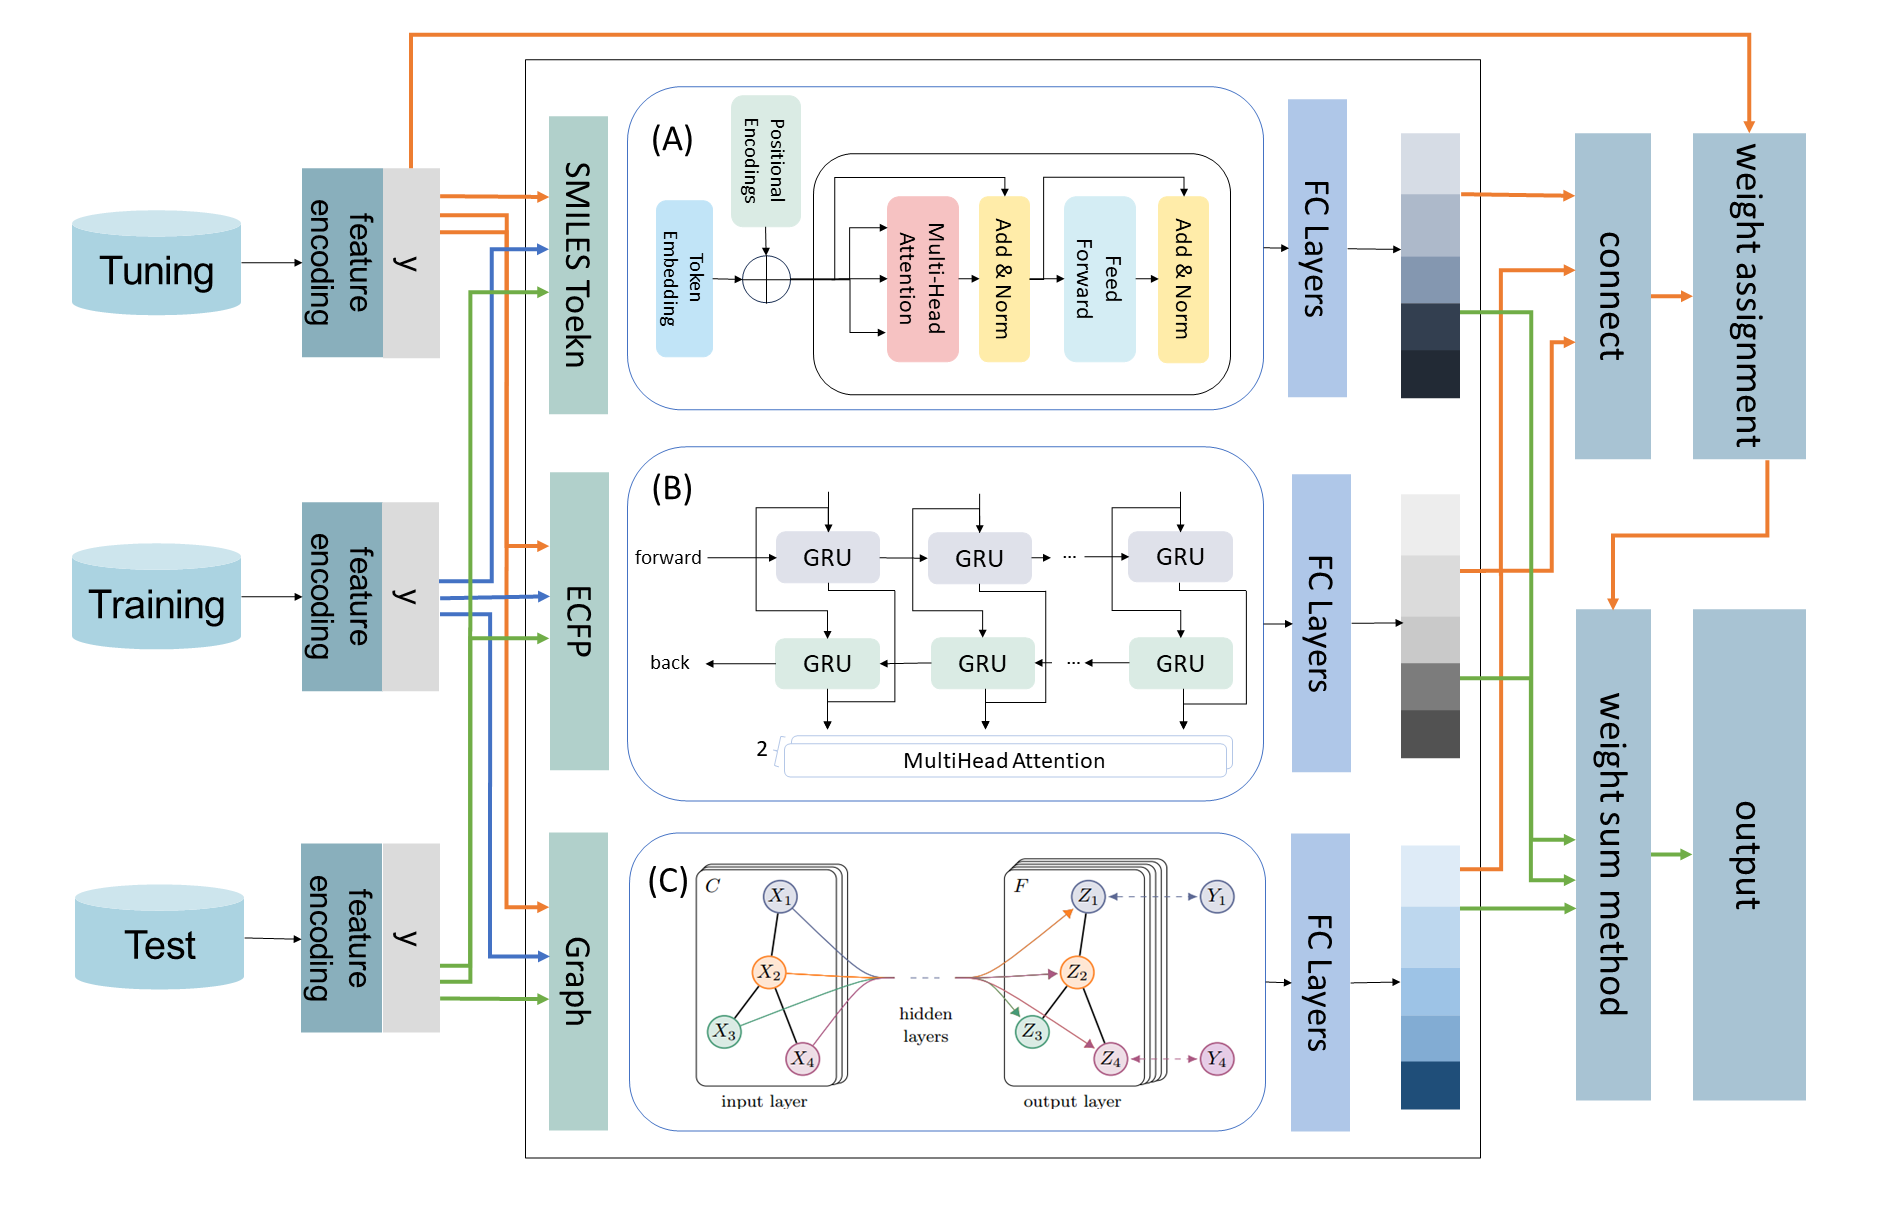

In [1]:
from PIL import Image
from IPython.display import display
img = Image.open('MMFDL_model.png')
display(img)

Prepare training data and testing data.

In [1]:

# from myTrCPI.script.makeModel.utils_smiecfp import *
from sklearn import metrics
# from torch.utils.data import Dataset, DataLoader
# from torch_geometric.data import InMemoryDataset, DataLoader
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import warnings
from sklearn.linear_model import ElasticNet
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sys

sys.path.append('../util')
from utils_smiecfp import *
from data_gen_modify import *
from analysis import *
from utils import *

sys.path.append('../model')
from model_combination import *

warnings.filterwarnings("ignore", category=UserWarning, module="torch_geometric")

gpu_index = 0  # 可以根据需要更改为其他 GPU 编号

# 检查是否有可用的 GPU 设备
if torch.cuda.is_available():
    # 设置为指定的 GPU 设备
    device = torch.device(f'cuda:{gpu_index}')
else:
    # 如果没有可用的 GPU，使用 CPU
    device = torch.device('cpu')




epochs = 50
batch_size = 16
label = 10000
random_state= 42

argsCom = {
    'num_features_smi': 44,
    'num_features_ecfp':1024,
    'num_features_x': 78,
    'dropout': 0.1, 
    'num_layer': 4,
    'num_heads': 4,
    'hidden_dim': 256,
    'output_dim': 128,
    'n_output': 1
    
}

resultLoss = {'losses_train': [], 'losses_val': []}

train_data = formDataset(root='../dataSour', dataset='data_train')
train_ratio = 0.8
num_data = len(train_data)
indices = list(range(num_data))
train_indices, val_indices = train_test_split(indices, train_size=train_ratio, shuffle=True, random_state=random_state)
train_dataset = [train_data[i] for i in train_indices]
val_dataset = [train_data[i] for i in val_indices]
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_data = formDataset(root='../dataSour', dataset='data_test')
testLoader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)


Pre-processed data found: ../dataSour/processed/data_train.pt, loading ...
Pre-processed data found: ../dataSour/processed/data_test.pt, loading ...


Extracting features from different representations

In [4]:
learning_rate = 0.0001
com_model = comModel(argsCom).to(device)
optimizer_com = torch.optim.Adam(com_model.parameters(), lr=learning_rate)
criterion_com = torch.nn.MSELoss()

com_model.train()
for i in range(epochs):
    print("Running EPOCH",i+1)
    total_loss = 0
    n_batches = 0
    correct = 0
    '''
        train部分
    '''
    for batch_idx, data in enumerate(trainLoader):
        encodedSmi = torch.LongTensor(data.smi).to(device)
        encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
        ecfp = torch.FloatTensor(data.ep).to(device)
        y = data.y.to(device)
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)
        y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch)
        loss1 = criterion_com(y_pred[0].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss2 = criterion_com(y_pred[1].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss3 = criterion_com(y_pred[2].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss = (loss1 + loss2 + loss3) / 3
        total_loss += (loss.data)/3
        optimizer_com.zero_grad()
        loss.backward()
        torch.cuda.empty_cache()
        torch.nn.utils.clip_grad_norm_(com_model.parameters(),0.5)
        optimizer_com.step()
        n_batches+=1
        
    avg_loss = total_loss / n_batches
    resultLoss['losses_train'].append(avg_loss)
    print('train avg_loss is: ', avg_loss.item())

    '''
        val部分
    '''
    total_loss = 0
    n_batches = 0
    correct = 0
    for batch_idx, data in enumerate(valLoader):
        encodedSmi = torch.LongTensor(data.smi).to(device)
        encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
        ecfp = torch.FloatTensor(data.ep).to(device)
        y = data.y.to(device)
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)
        y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch) 
        loss1 = criterion_com(y_pred[0].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss2 = criterion_com(y_pred[1].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss3 = criterion_com(y_pred[2].type(torch.DoubleTensor), y.type(torch.DoubleTensor))
        loss = (loss1 + loss2 + loss3) / 3
        total_loss += (loss.data)/3
        optimizer_com.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(com_model.parameters(),0.5)
        optimizer_com.step()
        n_batches+=1
        torch.cuda.empty_cache()
    avg_loss = total_loss / n_batches
    resultLoss['losses_val'].append(avg_loss) 
    print('val avg_loss is: ', avg_loss.item())
    print('\n')

val_data = []
pred_data1 = []
pred_data2 = []
pred_data3 = []
com_model.eval()
for batch_idx, data in enumerate(valLoader):
    encodedSmi = torch.LongTensor(data.smi).to(device)
    encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
    ecfp = torch.FloatTensor(data.ep).to(device)
    y = data.y.to(device)
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    batch = data.batch.to(device)
    y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch)
    val_data.append(y.tolist())
    pred_data1.append(y_pred[0].tolist())
    pred_data2.append(y_pred[1].tolist())
    pred_data3.append(y_pred[2].tolist()) 

'''
    Weight analysis 
'''
def flattened_data(data):
    fla_data = [item for sublist in data for item in sublist]
    merged_data = np.array(fla_data).flatten() 
    return merged_data

data_ = {}
data_['pred1'] = flattened_data(pred_data1)
data_['pred2'] = flattened_data(pred_data2)
data_['pred3'] = flattened_data(pred_data3)
data_['true'] = flattened_data(val_data)

val_true = data_['true']
val_pred = np.column_stack((data_['pred1'], data_['pred2'], data_['pred3']))

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(val_pred, val_true)
lasso_weights = lasso_model.coef_
print("Lasso Weights:", lasso_weights)

elastic_net = ElasticNet(alpha=0.5, l1_ratio=0.5)
elastic_net.fit(val_pred, val_true)
elastic_weights = elastic_net.coef_
print("elastic weight:", elastic_weights)

RF = RandomForestRegressor()
RF.fit(val_pred, val_true)
RF_importances = RF.feature_importances_
print("RF weight:", RF_importances)

gradientboost = GradientBoostingRegressor(n_estimators=40, learning_rate=0.1, max_depth=3, random_state=random_state)
gradientboost.fit(val_pred, val_true)
gradientboost_weights = gradientboost.feature_importances_
print("gradientboost_weights:", gradientboost_weights)

'Evaluate test'
sour_data = []
pred_data1 = []
pred_data2 = []
pred_data3 = []
com_model.eval()
for batch_idx, data in enumerate(testLoader):
    encodedSmi = torch.LongTensor(data.smi).to(device)
    encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
    ecfp = torch.FloatTensor(data.ep).to(device)
    y = data.y.to(device)
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    batch = data.batch.to(device)
    y_pred = com_model(encodedSmi, encodedSmi_mask, ecfp, x, edge_index, batch)  
    sour_data.append(y.tolist())
    pred_data1.append(y_pred[0].tolist())
    pred_data2.append(y_pred[1].tolist())
    pred_data3.append(y_pred[2].tolist()) 

y_lasso = lasso_weights[0] * flattened_data(pred_data1) + lasso_weights[1] * flattened_data(pred_data2) + lasso_weights[2] * flattened_data(pred_data3)
y_ela = elastic_weights[0] * flattened_data(pred_data1) + elastic_weights[1] * flattened_data(pred_data2) + elastic_weights[2] * flattened_data(pred_data3)
y_tree = RF_importances[0] * flattened_data(pred_data1) + RF_importances[1] * flattened_data(pred_data2) + RF_importances[2] * flattened_data(pred_data3)
y_gradient = gradientboost_weights[0] * flattened_data(pred_data1) + gradientboost_weights[1] * flattened_data(pred_data2) + gradientboost_weights[2] * flattened_data(pred_data3)
y_sour = flattened_data(sour_data)


def calRmseMae(y, y_pred):
    yResult = {}
    ground_truth = y
    predictions = y_pred
    # calculate rmse
    squared_errors = (ground_truth - predictions) ** 2
    rmse = np.sqrt(np.mean(squared_errors))
    yResult['rmse'] = rmse
    # calculate mae
    absolute_errors = np.abs(ground_truth - predictions)
    mae = np.mean(absolute_errors)
    yResult['mae'] = mae
    return yResult

yResult = {}
yResult['lasso'] = calRmseMae(y_sour, y_lasso)
yResult['leastic'] = calRmseMae(y_sour, y_ela)
yResult['rf'] = calRmseMae(y_sour, y_tree)
yResult['gradientBoost'] = calRmseMae(y_sour, y_gradient)
print(yResult)

weightDic = {}
weightDic['lasso'] = lasso_weights
weightDic['elastic'] = elastic_weights
weightDic['rf'] = RF_importances
weightDic['gradientBoost'] = gradientboost_weights

Running EPOCH 1
train avg_loss is:  8.642002587640564
val avg_loss is:  6.122715065800489


Running EPOCH 2
train avg_loss is:  7.183064390644842
val avg_loss is:  5.018514340751072


Running EPOCH 3
train avg_loss is:  6.247462276351908
val avg_loss is:  4.335848914381087


Running EPOCH 4
train avg_loss is:  5.684855182566729
val avg_loss is:  3.777228081948735


Running EPOCH 5
train avg_loss is:  4.788806747576149
val avg_loss is:  3.3984576712897705


Running EPOCH 6
train avg_loss is:  4.3646237615041334
val avg_loss is:  3.1563522966850184


Running EPOCH 7
train avg_loss is:  4.185627201481489
val avg_loss is:  2.9873229857311827


Running EPOCH 8
train avg_loss is:  3.9751491131370114
val avg_loss is:  2.9880640183615697


Running EPOCH 9
train avg_loss is:  5.855486847113832
val avg_loss is:  2.7786022782448057


Running EPOCH 10
train avg_loss is:  3.8632277718305126
val avg_loss is:  2.7186422671677803


Running EPOCH 11
train avg_loss is:  3.637702978478814
val avg_loss is

Save results

Tri_LASSO
pearson:  (0.942159452978081, 8.909754482494673e-39)
0.8698624684593116 0.9421594529780806


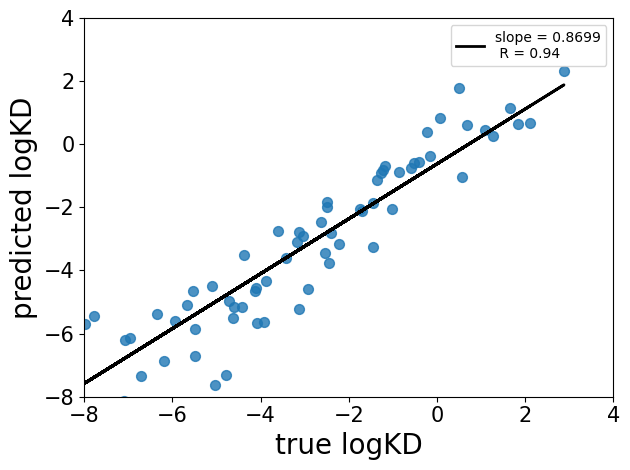

Tri_Elastic
pearson:  (0.9423237048994397, 7.999412646760256e-39)
0.8457588273380976 0.9423237048994396


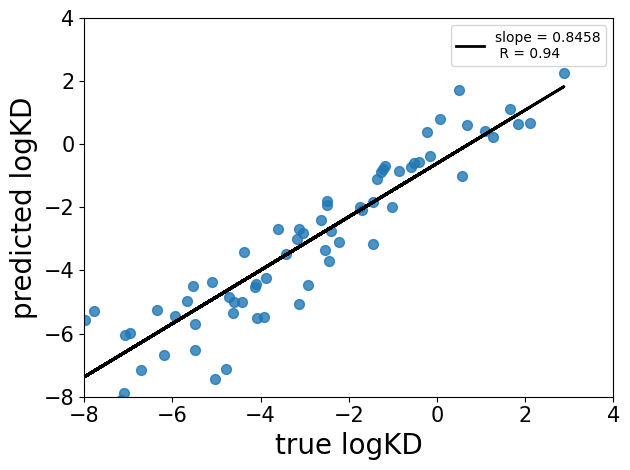

Tri_RF
pearson:  (0.9361738550773784, 3.699625412944438e-37)
0.9401662021891473 0.9361738550773778


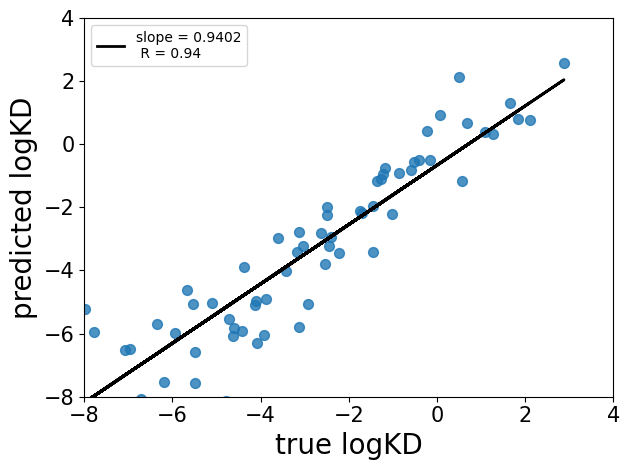

Tri_GB
pearson:  (0.9343373919697435, 1.0798777188772678e-36)
0.9366135023997284 0.9343373919697431


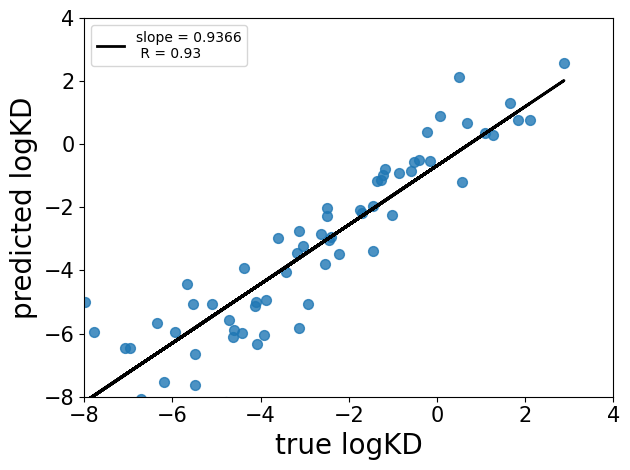



../result/ML/10000-result-16-50-42-lasso-com.csv	saved successfully
../result/ML/10000-result-16-50-42-elastic-com.csv	saved successfully
../result/ML/10000-result-16-50-42-rf-com.csv	saved successfully
../result/ML/10000-result-16-50-42-gradient-com.csv	saved successfully


../result/ML/10000_validation_16_50_42_data.csv	save succeed!


In [5]:
savePath = '../result/ML/{}_rmseMae_{}_{}_{}_weight_com.csv'.format(label, batch_size, epochs, random_state)
rmseAndMae(yResult, savePath)
savePath = '../result/ML/{}_weight_{}_{}_{}_weight_com.csv'.format(label, batch_size, epochs, random_state)
df_weight = pd.DataFrame(weightDic)
df_weight.to_csv(savePath, index=False)

print('Tri_LASSO')
savePath = '../result/ML/{}_scatter_predited_{}_{}_{}_lasso_com.png'.format(label, batch_size, epochs, random_state)
pltPredict_linregress(y_lasso, y_sour, savePath)
print('Tri_Elastic')
savePath = '../result/ML/{}_scatter_predited_{}_{}_{}_elastic_com.png'.format(label, batch_size, epochs, random_state)
pltPredict_linregress(y_ela, y_sour, savePath)
print('Tri_RF')
savePath = '../result/ML/{}_scatter_predited_{}_{}_{}_rf_com.png'.format(label, batch_size, epochs, random_state)
pltPredict_linregress(y_tree, y_sour, savePath)
print('Tri_GB')
savePath = '../result/ML/{}_scatter_predited_{}_{}_{}_gradient_com.png'.format(label, batch_size, epochs, random_state)
pltPredict_linregress(y_gradient, y_sour, savePath)
print('\n')

result = {}
result['y_pred'] = y_lasso
result['y'] = y_sour
resultPath = '../result/ML/{}-result-{}-{}-{}-lasso-com.csv'.format(label, batch_size, epochs, random_state)
resultDf = pd.DataFrame(result)
resultDf.to_csv(resultPath, index=False)
print(resultPath + '\tsaved successfully')
result = {}
result['y_pred'] = y_ela
result['y'] = y_sour
resultPath = '../result/ML/{}-result-{}-{}-{}-elastic-com.csv'.format(label, batch_size, epochs, random_state)
resultDf = pd.DataFrame(result)
resultDf.to_csv(resultPath, index=False)
print(resultPath + '\tsaved successfully')
result = {}
result['y_pred'] = y_tree
result['y'] = y_sour
resultPath = '../result/ML/{}-result-{}-{}-{}-rf-com.csv'.format(label, batch_size, epochs, random_state)
resultDf = pd.DataFrame(result)
resultDf.to_csv(resultPath, index=False)
print(resultPath + '\tsaved successfully')
result = {}
result['y_pred'] = y_gradient
result['y'] = y_sour
resultPath = '../result/ML/{}-result-{}-{}-{}-gradient-com.csv'.format(label, batch_size, epochs, random_state)
resultDf = pd.DataFrame(result)
resultDf.to_csv(resultPath, index=False)
print(resultPath + '\tsaved successfully')
print('\n')

savePath = '../result/ML/{}_loss_{}_{}_{}_weight_com.png'.format(label, batch_size, epochs, random_state)

savePath = '../result/ML/{}_loss_{}_{}_{}_weight_com.csv'.format(label, batch_size, epochs, random_state)
lossDf = pd.DataFrame(resultLoss)
lossDf.to_csv(savePath, index=False)

savePath = '../result/ML/{}_validation_{}_{}_{}_data.csv'.format(label, batch_size, epochs, random_state)
data_as_lists = {key: data_[key].tolist() for key in data_}
df_data = pd.DataFrame(data_as_lists)
df_data.to_csv(savePath, index=False)
print(savePath + '\tsave succeed!')